In [4]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

# J comparison of gene networks from human interactome, cellmaps, omnipath,

In [68]:
# gwps = get_perturb_gt()
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

In [2]:
gwps.var.index = gwps.var.gene_name
gwps = gwps.extract_links()

NameError: name 'gwps' is not defined

In [5]:
# extracting PPI data from "computing the human interactome"
humaninter = pd.read_csv(
    "http://prodata.swmed.edu/humanPPI/bulk_download/GoodPairs.txt",
    sep="\t",
    skiprows=4,
)

In [62]:
# getting U2OS cell map data
import json
import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of nodes: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)


Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842


In [ ]:
omni_s = set([s + "_" + t for s, t in omni.iloc[:, :2].values])
collectri_s = set([s + "_" + t for s, t in collectri.iloc[:, :2].values])
gwps_s = set([s + "_" + t for s, t in gwps.iloc[:, :2].values])
humaninter_s = set([s + "_" + t for s, t in humaninter.iloc[:, 2:4].values])
cellmap_s = set([s + "_" + t for s, t in cellmap.iloc[:, [2, 4]].values])

In [26]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  63076
number of edges in humaninter:  29237
number of edges in cellmap:  36842


In [50]:
humaninter

{'MSMO1_ARL6IP6',
 'CHRNB1_CHRND',
 'KRT15_KRT28',
 'ZNF655_EVL',
 'SDC3_SDC2',
 'KPNA2_FAM204A',
 'RSL1D1_DDX18',
 'MRPL50_MRPL15',
 'ADAR_TASOR2',
 'TFAP2A_TFAP2C',
 'LOC100653049_KRT32',
 'IGKV3-7_IGLL1',
 'UBE2W_OTUB1',
 'HGS_STAM',
 'SFRP5_C6orf120',
 'BCL2L11_BCL2',
 'OR2AK2_PPP1R14C',
 'IFT81_IFT74',
 'KRT3_KRT25',
 'TCP1_CDC37',
 'EPHA8_EFNA3',
 'LYAR_GAR1',
 'MT-CO1_MT-ND3',
 'CAVIN4_CAVIN3',
 'COMMD2_COMMD3',
 'DCTN1_HSPA12B',
 'NDUFS6_FOXRED1',
 'CLNK_GTSF1L',
 'MT-ND2_NDUFAF1',
 'CIT_DCTN1',
 'KRT19_ERC1',
 'PARD3_BRPF3',
 'IGLV10-54_IGLL1',
 'PTPN6_C8orf33',
 'SIRT6_ABCF2',
 'SEC61G_SEC61B',
 'FLT4_KDR',
 'TRAPPC6B_TRAPPC1',
 'APOBEC1_KRTAP6-2',
 'PTPRZ1_CYP3A7',
 'MRPL21_MRPL20',
 'NXT2_NXF1',
 'NFE2L2_BRPF3',
 'GSTA2_GSTP1',
 'FIP1L1_SIRT6',
 'NKX6-1_FOXA2',
 'S100PBP_PCED1A',
 'ASXL2_BAP1',
 'TUBA3E_TUBB1',
 'CLEC4D_TIMD4',
 'NKAP_FAM50B',
 'IGLV11-55_IGLL1',
 'MIER1_HDAC2',
 'RFXANK_CLK3',
 'ARHGEF10_ARHGEF10L',
 'OR51L1_CD300A',
 'IGLL5_IGKV1D-16',
 'KRT36_KRT39',
 'T

In [39]:
cellmap

{'NPM3_SENP5',
 'LRCH1_DOCK7',
 'NPTN_DSTYK',
 'DHX8_USP42',
 'ZSCAN5A_RRP7A',
 'PBXIP1_NDUFA2',
 'CD68_FAM114A2',
 'GALNS_SLC25A16',
 'RIC3_CEP192',
 'TTC23L_EFCAB7',
 'POP7_LAGE3',
 'TMEM88_SLC12A4',
 'PSMB7_PSMD6',
 'TERF1_ACD',
 'FBXW7_FBXO45',
 'SPIN1_TOPORS',
 'HSPA8_IRF2BP2',
 'HMGA1_TRIP12',
 'ARHGEF35_CCZ1B',
 'TNFRSF6B_ANKRD50',
 'DCAF8_PIP5K1A',
 'COPS3_DDB2',
 'EPB41L5_PRCP',
 'IFT81_IFT74',
 'HSP90AB1_DUSP14',
 'YWHAB_KCTD3',
 'S1PR3_ZDHHC5',
 'CHRNB1_BNIP1',
 'COMMD2_COMMD3',
 'FTL_SKA1',
 'CD27_DTYMK',
 'SIRT6_PML',
 'MUCL1_PDIA5',
 'APLNR_ADGRG1',
 'FAM219A_MRE11',
 'IRF2BP1_RAB34',
 'HMGCL_PNPT1',
 'MFGE8_ENO3',
 'PYM1_ZC3H8',
 'PTH2R_OSMR',
 'TNFSF8_HAUS5',
 'AURKB_TBC1D9B',
 'CREB3_SOAT1',
 'TAX1BP3_AMER1',
 'CRCP_NUDT3',
 'RAB11B_NCKIPSD',
 'PEX7_RAB2B',
 'EGFL8_MPO',
 'RACK1_N4BP2',
 'EAF1_PIP5K1C',
 'SNRNP70_GEMIN5',
 'CCKBR_PIGO',
 'RAD23A_MPG',
 'SLC22A16_TMBIM6',
 'ZNRD2_MGA',
 'FBXW7_HAL',
 'C9orf40_TRAPPC10',
 'WASHC3_BLOC1S4',
 'XXYLT1_PDCD2L',
 'KBTBD7_EBI3

In [42]:
gwps

{'RPL7A_ZGPAT',
 'SLC35A3_DDX6',
 'EGFL7_SRP19',
 'ADI1_CHORDC1',
 'PIK3CB_DNMT1',
 'PRPSAP2_LTV1',
 'ZNF672_MBTPS2',
 'CCNA2_DENR',
 'TALDO1_ILF3',
 'GIHCG_PTGR2',
 'PTMS_DLD',
 'ZNF117_GTF2H1',
 'LCP1_MRPS17',
 'FAM136A_FBXW11',
 'MRPL33_MRPL10',
 'HAUS2_DPY19L4',
 'ZNF431_BRIX1',
 'WDR18_EIF3H',
 'MLLT10_DDX10',
 'PPIE_EIF3J',
 'BRD4_NHP2',
 'RCN2_POLR2M',
 'ACAT2_SCAP',
 'S100A13_POLR1B',
 'WDFY2_MED28',
 'HSPA5_EIF3A',
 'CTNNBIP1_RNF40',
 'RPP21_ESF1',
 'MRPL12_MRPS34',
 'PKP4_CSTF3',
 'UBC_SDAD1',
 'GATA2_POLR2G',
 'NACA_GPN3',
 'SERPINF1_TMEM115',
 'YBX1_MOV10',
 'SRRT_FUNDC2',
 'OAZ1_RMI1',
 'RPP25_MED30',
 'HEMGN_RPS10',
 'ELAC2_MED28',
 'PSMA2_RPL19',
 'CBX5_AARS',
 'ZNF511_TARS',
 'TXNRD1_MED28',
 'RPL34_HSPA5',
 'SOD1_INO80',
 'CENPJ_KDM1A',
 'SH3BGRL3_ABCB7',
 'VDAC3_RPAP2',
 'MT-CO2_NARS',
 'GOLPH3_TAF1',
 'NKTR_RNF31',
 'SRP68_EIF3A',
 'PLOD2_GPS2',
 'PDLIM2_KANSL2',
 'DDX1_CCNQ',
 'XPC_ING5',
 'C1orf43_MED21',
 'UQCRB_EEF1G',
 'MRPL2_GPN3',
 'RPSA_UTP18',
 'MED28_SUPT6H

In [46]:
humaninter

{'MSMO1_ARL6IP6',
 'CHRNB1_CHRND',
 'KRT15_KRT28',
 'ZNF655_EVL',
 'SDC3_SDC2',
 'KPNA2_FAM204A',
 'RSL1D1_DDX18',
 'MRPL50_MRPL15',
 'ADAR_TASOR2',
 'TFAP2A_TFAP2C',
 'LOC100653049_KRT32',
 'IGKV3-7_IGLL1',
 'UBE2W_OTUB1',
 'HGS_STAM',
 'SFRP5_C6orf120',
 'BCL2L11_BCL2',
 'OR2AK2_PPP1R14C',
 'IFT81_IFT74',
 'KRT3_KRT25',
 'TCP1_CDC37',
 'EPHA8_EFNA3',
 'LYAR_GAR1',
 'MT-CO1_MT-ND3',
 'CAVIN4_CAVIN3',
 'COMMD2_COMMD3',
 'DCTN1_HSPA12B',
 'NDUFS6_FOXRED1',
 'CLNK_GTSF1L',
 'MT-ND2_NDUFAF1',
 'CIT_DCTN1',
 'KRT19_ERC1',
 'PARD3_BRPF3',
 'IGLV10-54_IGLL1',
 'PTPN6_C8orf33',
 'SIRT6_ABCF2',
 'SEC61G_SEC61B',
 'FLT4_KDR',
 'TRAPPC6B_TRAPPC1',
 'APOBEC1_KRTAP6-2',
 'PTPRZ1_CYP3A7',
 'MRPL21_MRPL20',
 'NXT2_NXF1',
 'NFE2L2_BRPF3',
 'GSTA2_GSTP1',
 'FIP1L1_SIRT6',
 'NKX6-1_FOXA2',
 'S100PBP_PCED1A',
 'ASXL2_BAP1',
 'TUBA3E_TUBB1',
 'CLEC4D_TIMD4',
 'NKAP_FAM50B',
 'IGLV11-55_IGLL1',
 'MIER1_HDAC2',
 'RFXANK_CLK3',
 'ARHGEF10_ARHGEF10L',
 'OR51L1_CD300A',
 'IGLL5_IGKV1D-16',
 'KRT36_KRT39',
 'T

<Axes: >

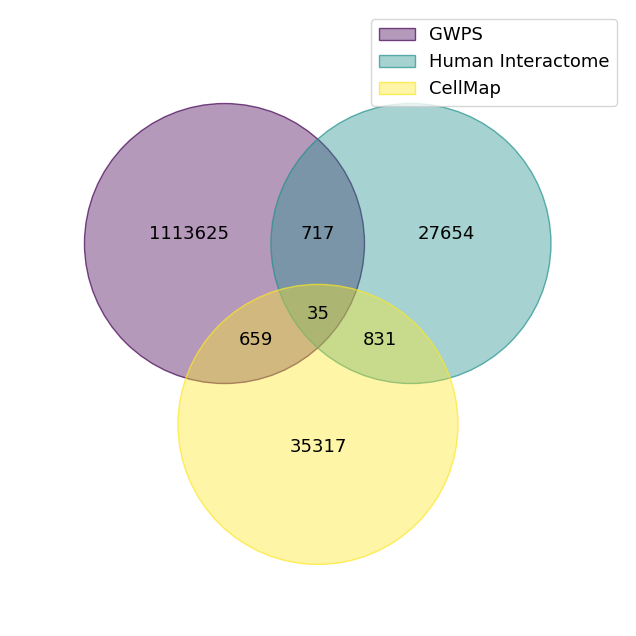

In [ ]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    "GWPS": gwps,
    "Human Interactome": humaninter,
    "CellMap": cellmap,
}

venn(sets)

<Axes: >

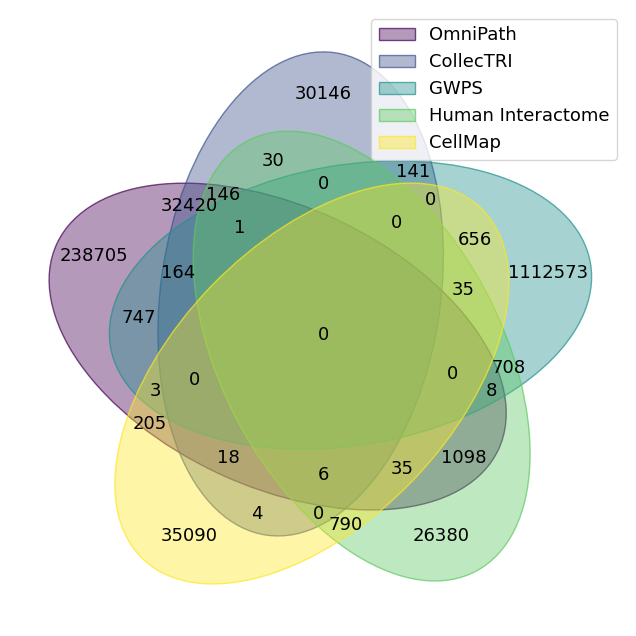

In [ ]:
sets = {
    "OmniPath": omni,
    "CollecTRI": collectri,
    "GWPS": gwps,
    "Human Interactome": humaninter,
    "CellMap": cellmap,
}

venn(sets)

<Axes: >

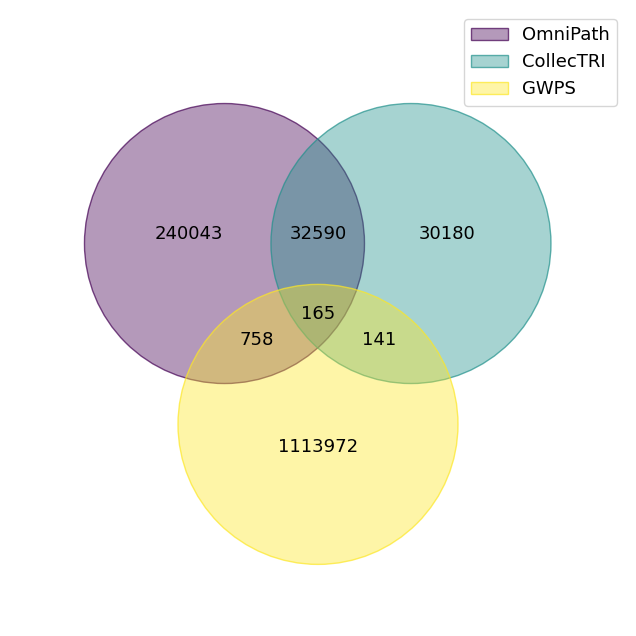

In [ ]:
sets = {
    "OmniPath": omni,
    "CollecTRI": collectri,
    "GWPS": gwps,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

## predict human interactome network

In [36]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from huggingface_hub import hf_hub_download

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import joblib

%load_ext autoreload
%autoreload 2 

import torch

torch.set_float32_matmul_precision("medium")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
model_checkpoint_file = "../../../da6ao55o.ckpt"  # w937u4o1.ckpt"


In [37]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

FYI: scPrint is not attached to a `Trainer`.


In [38]:
CELLTYPES = ["oligodendrocyte"]

NUM_GENES = 5000
MAXCELLS = 1024
LOC = "../..data/temp/"  #

In [39]:
# only dataset dropped
adata = sc.read(
    LOC + "glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

adata.var["isTF"] = False
adata.var.loc[adata.var.feature_name.isin(grnutils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 3589 × 22149
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered'

In [1]:
adata.obs.cell_type.value_counts()

NameError: name 'adata' is not defined

In [40]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 7 genes not known to the ontology
Removed 0 duplicate genes
Added 48469 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
done
AnnData object with n_obs × n_vars = 3567 × 70611
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_

In [41]:
model = model.to("cuda")

number of expressed genes in this cell type: 12951
not on wandb, could not set name


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


base enrichment
Top central genes: []


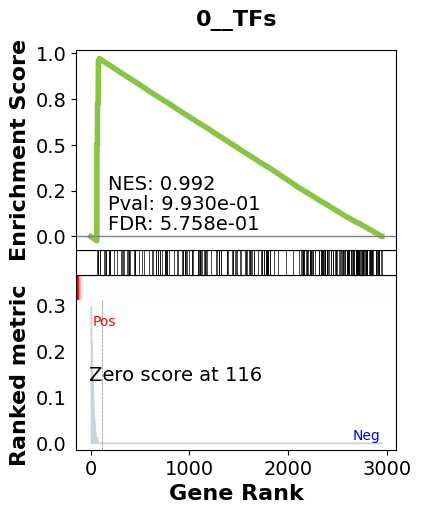

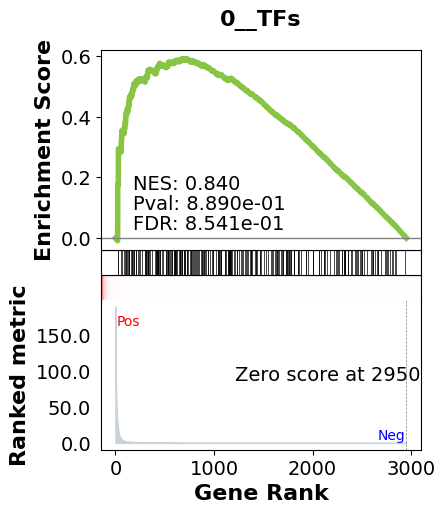

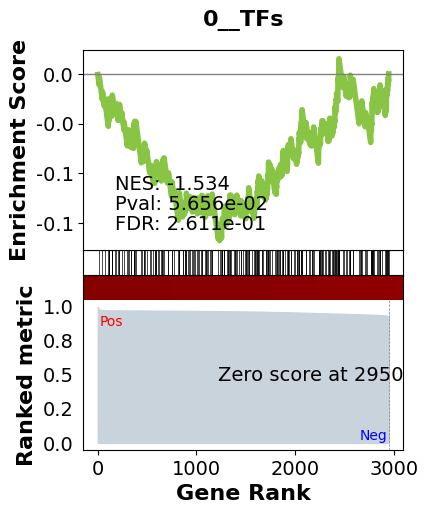

_________________________________________
TF specific enrichment
found some significant results for  23.076923076923077 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1101 genes
intersection pct: 0.37309386648593695
only tf:  False
using only tf:  0.37309386648593695
total true edges:  4028.0
precision:  0.003322881271340314 
recall:  1.0 
random precision: 0.003325902072496078


 83%|████████▎ | 106/128 [00:00<00:00, 524.98it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:921: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 520.98it/s]


Average Precision (AP):  0.003750802443053273
Area Under Precision-Recall Curve (AUPRC):  0.0037466827140763166
EPR: 0.5955555555555555


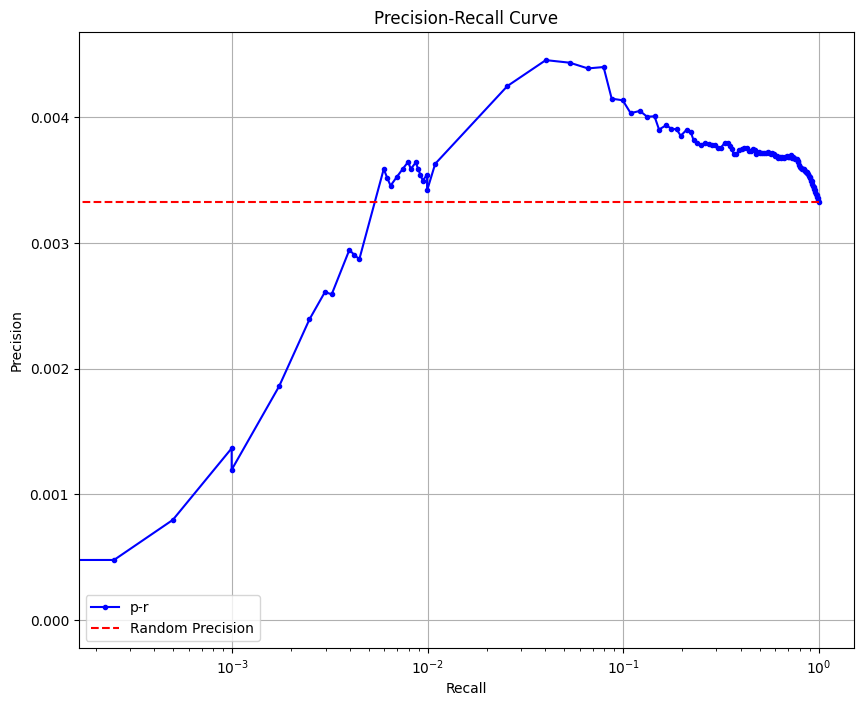

In [42]:
metrics = {}
clf_omni = None
shapes = []
for celltype in CELLTYPES:
    grn_inferer = GNInfer(
        how="most var within",
        preprocess="softmax",
        head_agg="none",
        filtration="none",
        num_genes=3000,
        max_cells=64,
        doplot=False,
        num_workers=8,
        batch_size=8,
    )
    grn = grn_inferer(model, adata[adata.X.sum(1) > 500], cell_type=celltype)
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    grn.varp["all"] = grn.varp["GRN"]
    grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
    metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

In [ ]:
from scdataloader.utils import load_genes
import anndata as ad
import pandas as pd
import bionty as bt
from grnndata import from_adata_and_longform

# Load gene names
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata


Created empty AnnData with 70611 genes


AnnData object with n_obs × n_vars = 1 × 70611
    var: 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism'

In [ ]:
empty_adata.var["ensembl_id"] = empty_adata.var.index

In [ ]:
empty_adata.var.set_index("symbol", inplace=True, drop=False)

In [ ]:
gt_cm = from_adata_and_longform(empty_adata, cellmap.iloc[:, [2, 4]])

100%|██████████| 36842/36842 [00:12<00:00, 2862.88it/s]


In [53]:
gt_inter = from_adata_and_longform(empty_adata, humaninter.iloc[:, 2:4])

100%|██████████| 29246/29246 [00:12<00:00, 2323.62it/s]


loading GT,  collectri
intersection of 273 genes
intersection pct: 0.09251101321585903
only tf:  False
using only tf:  0.09251101321585903
total true edges:  794.0
precision:  0.010653571093131533 
recall:  1.0 
random precision: 0.010692738633915105


100%|██████████| 128/128 [00:00<00:00, 3930.99it/s]

Average Precision (AP):  0.012783318208628228
Area Under Precision-Recall Curve (AUPRC):  0.012728739686980517
EPR: 2.426670405758201


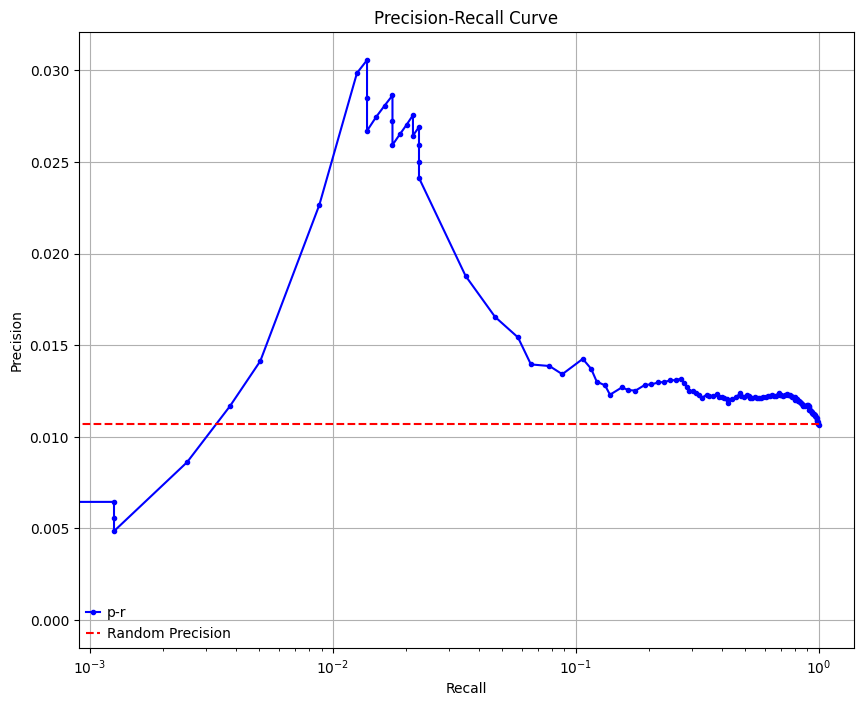

{'precision': 0.010653571093131533,
 'recall': 1.0,
 'rand_precision': 0.010692738633915105,
 'auprc': 0.012728739686980517,
 'ap': 0.012783318208628228,
 'epr': 2.426670405758201}

In [70]:
BenGRN(grn).compare_to(to="collectri")

precision:  0.001148767078244344 
recall:  1.0 
random precision: 0.0011491225136027116


100%|██████████| 128/128 [00:00<00:00, 479.10it/s]


Average Precision (AP):  0.0010514787764140496
Area Under Precision-Recall Curve (AUPRC):  0.0010500816571582287
EPR: 1.0555977658409303


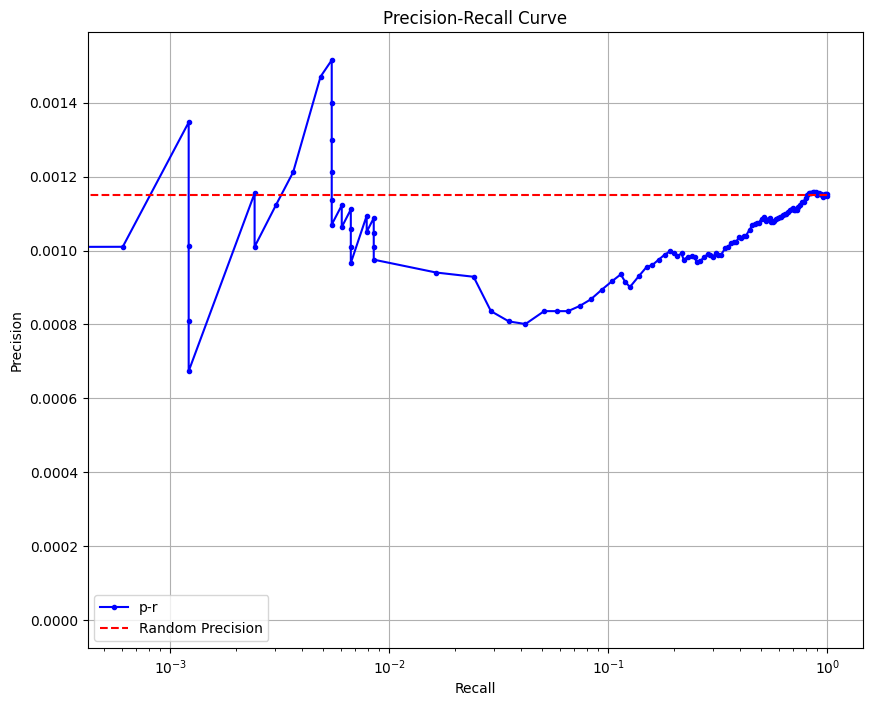

{'precision': 0.001148767078244344,
 'recall': 1.0,
 'rand_precision': 0.0011491225136027116,
 'auprc': 0.0010500816571582287,
 'ap': 0.0010514787764140496,
 'epr': 1.0555977658409303}

In [66]:
BenGRN(grn).compare_to(gt_cm)

precision:  0.00020743278754726543 
recall:  1.0 
random precision: 0.00020749696848400655


100%|██████████| 128/128 [00:01<00:00, 116.41it/s]


Average Precision (AP):  0.0002308226234513565
Area Under Precision-Recall Curve (AUPRC):  0.00022886212714395422
EPR: 0.0


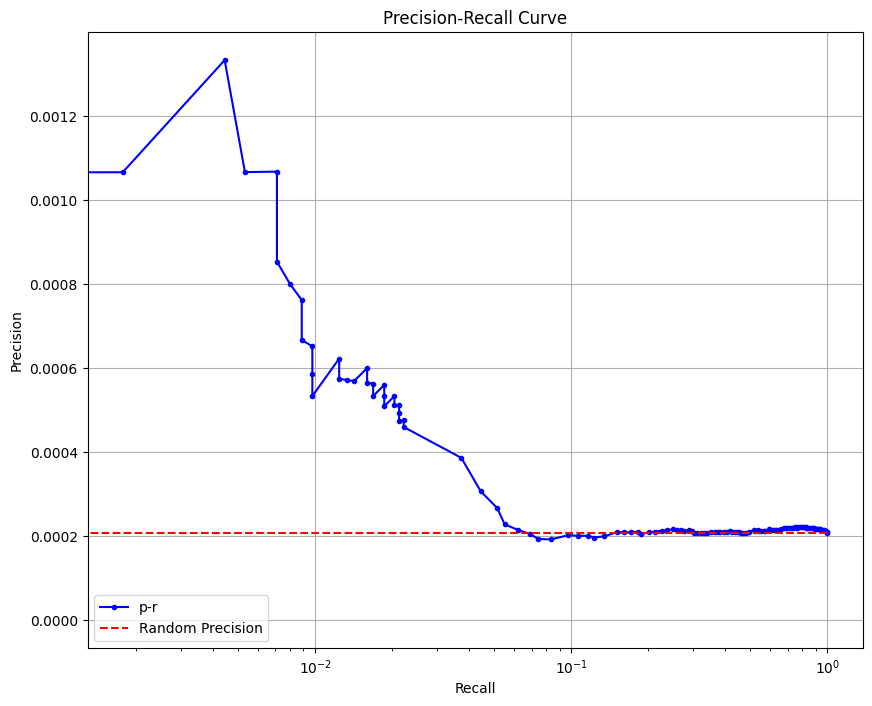

{'precision': 0.00020743278754726543,
 'recall': 1.0,
 'rand_precision': 0.00020749696848400655,
 'auprc': 0.00022886212714395422,
 'ap': 0.0002308226234513565,
 'epr': 0.0}

In [57]:
BenGRN(grn).compare_to(gt_inter)

# J look at nodes that stay the same across similar cells, different cell types (HOW??), species (human / mouse / chimp) (select a module of ~15 genes

In [72]:
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1842
neoplastic cell                   1079
oligodendrocyte precursor cell     406
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            50
neuron                              21
Name: count, dtype: int64

In [75]:
metrics = {}
clf_omni = None
shapes = []
for celltype in CELLTYPES:
    grn_inferer = GNInfer(
        how="most var within",
        preprocess="softmax",
        head_agg="none",
        filtration="none",
        num_genes=13000,
        max_cells=64,
        doplot=False,
        num_workers=8,
        batch_size=4,
    )
    grn = grn_inferer(model, adata[adata.X.sum(1) > 500], cell_type=celltype)
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    grn.varp["all"] = grn.varp["GRN"]
    grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
    # metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

number of expressed genes in this cell type: 12951
not on wandb, could not set name


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


base enrichment
too many genes for central computation


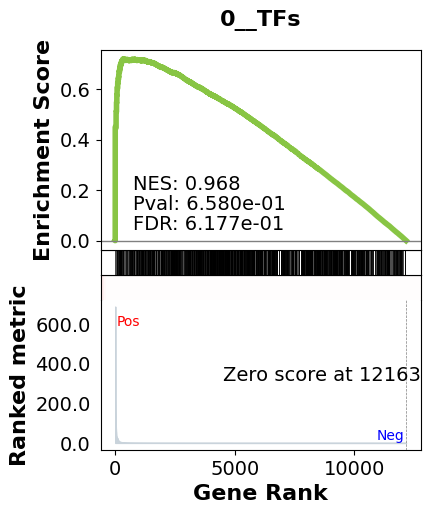

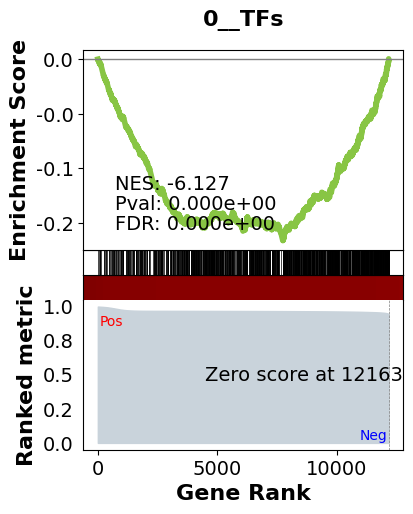

_________________________________________
TF specific enrichment
found some significant results for  51.61290322580645 % TFs

_________________________________________
loading GT,  omnipath
intersection of 4503 genes
intersection pct: 0.3701907267346268
only tf:  False
using only tf:  0.3701907267346268
total true edges:  55538.0
precision:  0.002738964114480592 
recall:  1.0 
random precision: 0.0027395725027779005


100%|██████████| 128/128 [00:04<00:00, 28.45it/s]


Average Precision (AP):  0.002967948073243567
Area Under Precision-Recall Curve (AUPRC):  0.002965242441940204
EPR: 1.4561332820095705


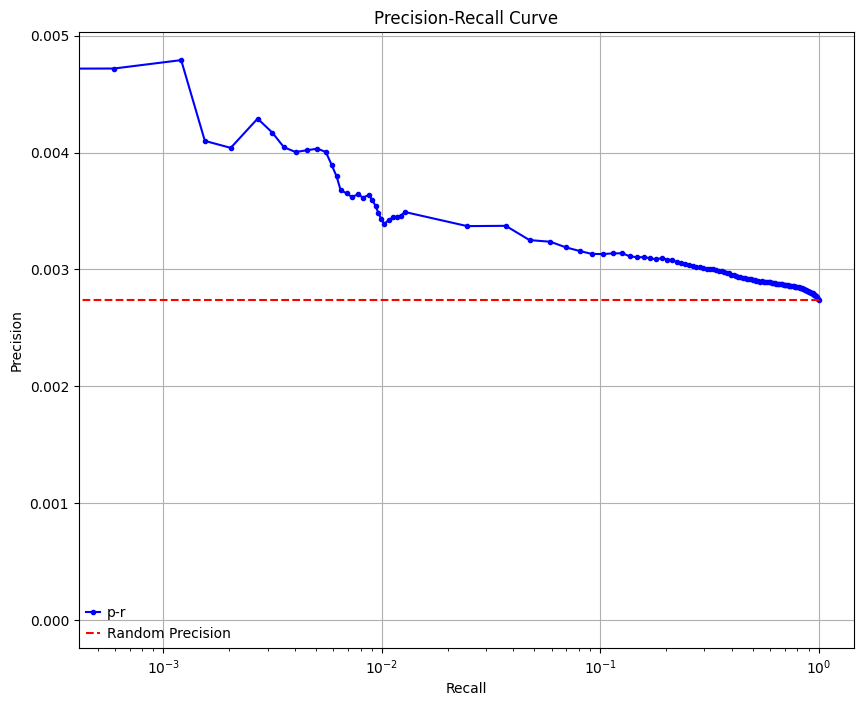

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Oligodendrocytes',
  'celltype.gmt__Hepatocytes',
  'celltype.gmt__Enterocytes',
  'celltype.gmt__Immune system cells',
  'celltype.gmt__Non-classical monocytes',
  'celltype.gmt__Hepatic stellate cells',
  'celltype.gmt__Retinal progenitor cells',
  'celltype.gmt__Pancreatic stellate cells',
  'celltype.gmt__Kupffer cells',
  'celltype.gmt__Airway goblet cells',
  'celltype.gmt__Hepatoblasts',
  'celltype.gmt__Neutrophils',
  'celltype.gmt__Granulocytes',
  'celltype.gmt__Ductal cells',
  'celltype.gmt__Neuroepithelial cells',
  'celltype.gmt__Fibroblasts',
  'celltype.gmt__Glial cells',
  'celltype.gmt__Enterochromaffin cells',
  'celltype.gmt__Memory CD4+ T cells',
  'celltype.gmt__Progenitor cells',
  'celltype.gmt__Intermediate monocytes',
  'celltype.gmt__Basal cells (Airway progenitor cells)',
  'celltype.gmt__Microglial cells',
  'celltype.gmt__Acinar cells',
  'celltype.gmt__Mast cells',
  'celltype.gmt__Alveolar macr

: 

In [ ]:
BenGRN(grn).scprint_benchmark()

loading GT,  collectri
intersection of 1191 genes
intersection pct: 0.09791187109503453
only tf:  False
using only tf:  0.09791187109503453
total true edges:  12826.0
precision:  0.009042066830644895 
recall:  1.0 
random precision: 0.009049665206132831


100%|██████████| 128/128 [00:00<00:00, 373.23it/s]


Average Precision (AP):  0.009658661585757152
Area Under Precision-Recall Curve (AUPRC):  0.0096526120457727
EPR: 1.3258872210578294


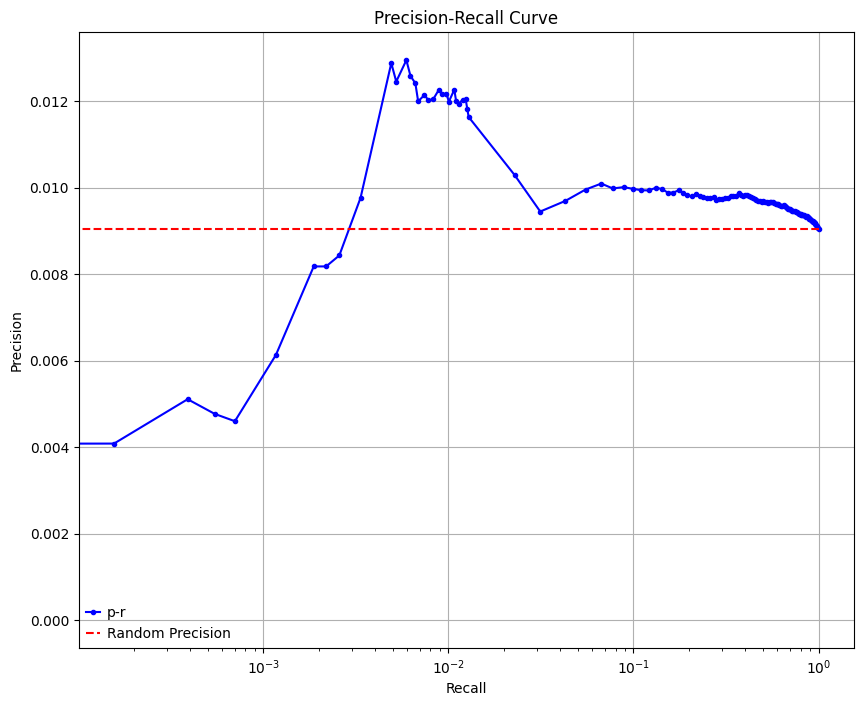

precision:  0.00017526031492823507 
recall:  1.0 
random precision: 0.00017527318468259903


100%|██████████| 128/128 [00:20<00:00,  6.17it/s]


Average Precision (AP):  0.00018174779158059082
Area Under Precision-Recall Curve (AUPRC):  0.00018148305658510945
EPR: 1.8251981047142034


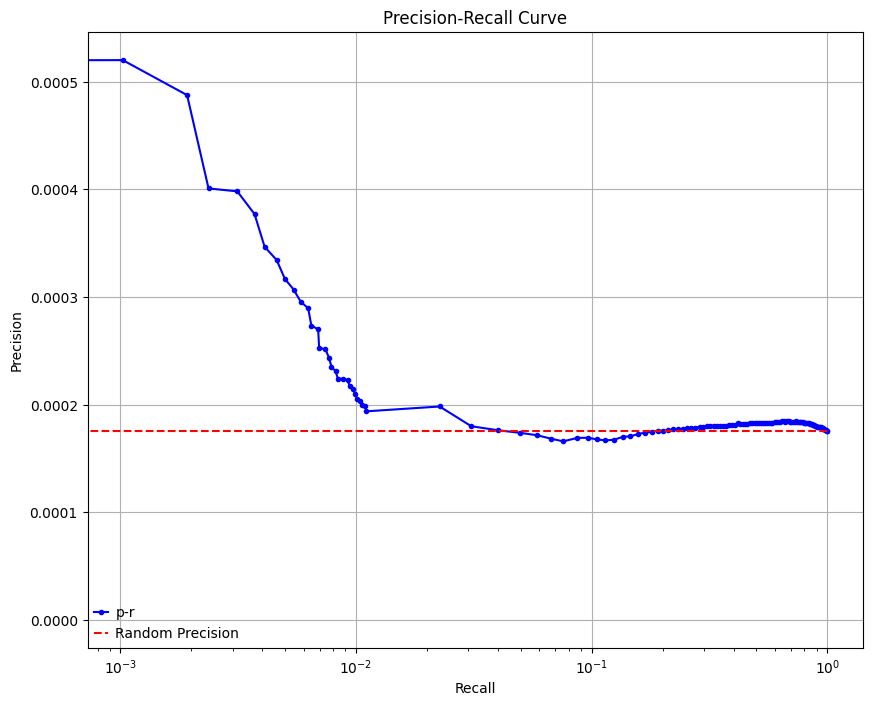

In [ ]:
BenGRN(grn).compare_to(to="collectri")
BenGRN(grn).compare_to(gt_inter)
BenGRN(grn).compare_to(gt_cm)

loading GT,  collectri
intersection of 789 genes
intersection pct: 0.10637724147229338
only tf:  False
using only tf:  0.10637724147229338
total true edges:  5853.0
precision:  0.009402092459531485 
recall:  1.0 
random precision: 0.009414024048947135


100%|██████████| 128/128 [00:00<00:00, 470.15it/s]


Average Precision (AP):  0.010856435260115573
Area Under Precision-Recall Curve (AUPRC):  0.010841306239007198
EPR: 1.7672397008494904


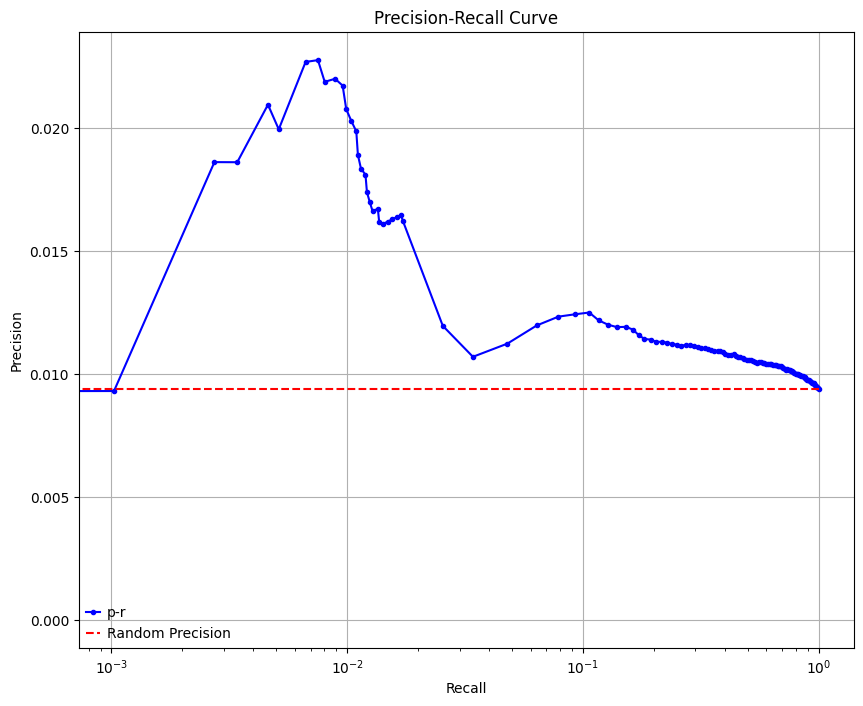

precision:  0.00015343270342985481 
recall:  1.0 
random precision: 0.00015345120713263218


100%|██████████| 128/128 [00:06<00:00, 20.88it/s]


Average Precision (AP):  0.00016257064855067433
Area Under Precision-Recall Curve (AUPRC):  0.00016157106782395378
EPR: 5.37851462273678


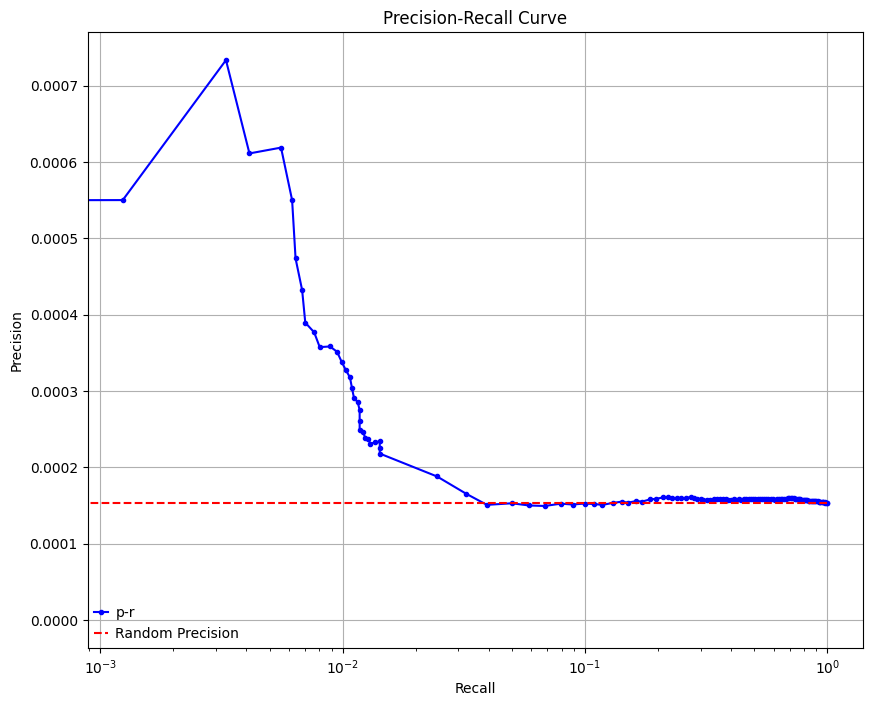

precision:  0.000845423839273101 
recall:  1.0 
random precision: 0.0008455257958383775


100%|██████████| 128/128 [00:01<00:00, 77.90it/s]


Average Precision (AP):  0.0007630712623028703
Area Under Precision-Recall Curve (AUPRC):  0.0007623535344999182
EPR: 0.5102403799056766


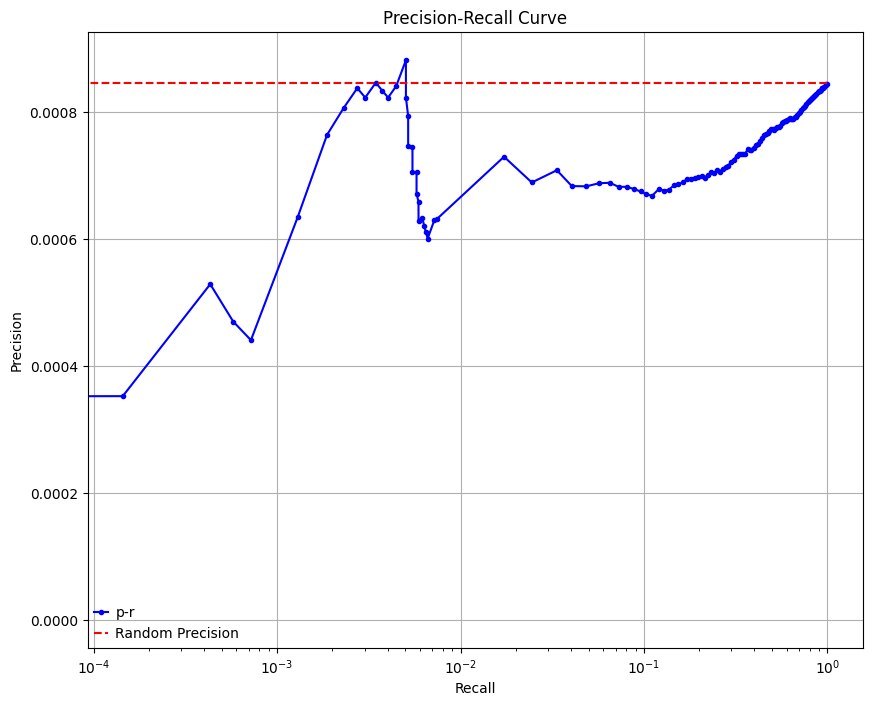

{'precision': 0.000845423839273101,
 'recall': 1.0,
 'rand_precision': 0.0008455257958383775,
 'auprc': 0.0007623535344999182,
 'ap': 0.0007630712623028703,
 'epr': 0.5102403799056766}

In [74]:
BenGRN(grn).compare_to(to="collectri")
BenGRN(grn).compare_to(gt_inter)
BenGRN(grn).compare_to(gt_cm)